In [25]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import tensorflow as tf

import scipy.io as spio

from datetime import datetime

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
from IPython.display import Image

### build a simple NN for  MNIST dataset

load the mnist dataset

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [5]:
n_inputs = 28*28  # MNIST
n_hidden1 = 30
n_outputs = 10 # digits 0-9, 10 classes


reset_graph()
# if batch size is 64, then x is 64 x 784
# if batch size is 128, then x is 128 x 784
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="input")   # "None" is for batch size
y = tf.placeholder(tf.int32, shape=(None), name="y")

x_image = tf.reshape(X,[-1,28,28,1])  # reshpae for 2d conv

In [6]:
learning_rate = 0.01

with tf.name_scope("dnn"):
#     conv1 = tf.layers.conv2d(x_image,  4, kernel_size=3, padding='same', name="conv1", use_bias=False)
#     conv2 = tf.layers.conv2d(conv1,  4, kernel_size=3, padding='same', name="conv2", use_bias=False)
    
    conv1 = tf.layers.conv2d(x_image,  4, kernel_size=3, padding='same', name="conv1", use_bias=True)
    conv2 = tf.layers.conv2d(conv1,  4, kernel_size=3, padding='same', name="conv2", use_bias=True)
    
    hidden1 = tf.layers.dense(tf.contrib.layers.flatten(conv2),   n_hidden1, name="hidden1", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)   

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    
t_vars = tf.trainable_variables()
conv1_kernel = [v for v in t_vars if 'conv1' in v.name  and 'kernel' in v.name][0] # 1st one in the list
conv2_kernel = [v for v in t_vars if 'conv1' in v.name  and 'kernel' in v.name][0]
# for v in tf.trainable_variables():
#     if "conv1" in v.name and "kernel" in v.name:
#         conv1_kern = 
    
    
#     if "conv" in v.name and "kernel" in v.name:
#         # 3 x 3 x 1 x 4
#         img_kernels = v
        
# #         #print(type(img_kernels))
# #         #print(img_kernels.shape)
        
# #         # 4 x 3 x 3 x 1 (one kernel per activation map and channel)
# #         img_kernels = tf.transpose(img_kernels, perm=[3, 0, 1, 2])
# #         # 4 x 3 x 3 x 1 (one kernel per activation map)
# #         img_kernels = tf.reduce_mean(img_kernels, axis=3, keep_dims=True)
#         print(v.name)
#         v_name = v.name[:-2]
#         print(v_name)
        
# #         tf.summary.image(v_name, img_kernels, max_outputs=4)

    




# summary = tf.summary.merge_all()


# if summary == None:
#     raise Exception("No summaries")


In [7]:
tf.trainable_variables()

[<tf.Variable 'conv1/kernel:0' shape=(3, 3, 1, 4) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'conv2/kernel:0' shape=(3, 3, 4, 4) dtype=float32_ref>,
 <tf.Variable 'conv2/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'hidden1/kernel:0' shape=(3136, 30) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'outputs/kernel:0' shape=(30, 10) dtype=float32_ref>,
 <tf.Variable 'outputs/bias:0' shape=(10,) dtype=float32_ref>]

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [10]:
n_epochs = 2
batch_size = 50

conv1_filter, conv2_filter = None, None

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            training_v = sess.run([training_op], feed_dict={X: X_batch, y: y_batch})
            #print(loss_v)
            
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        
        conv1_filter = conv1_kernel.eval()
        conv2_filter = conv2_kernel.eval()

#         if epoch % 2 == 0:
#             # write summary
#             summary_str = sess.run(summary, feed_dict={X: X_valid, y: y_valid})
#             summary_writer.add_summary(summary_str, epoch)
#             summary_writer.flush()
        
     
if conv1_filter is None:
    print("conv1_filter is None!")
    sys.exit(1)
    
if conv2_filter is None:
    print("conv2_filter is None!")
    sys.exit(1)

#     save_path = saver.save(sess, "./model_testFilter.ckpt")

0 Batch accuracy: 0.98 Validation accuracy: 0.9356
1 Batch accuracy: 0.96 Validation accuracy: 0.9488


In [12]:
conv1_filter.shape

(3, 3, 1, 4)

In [20]:
conv1_filter[:,:,0,3]

array([[ 0.14928599, -0.465646  , -0.53458607],
       [-0.0958581 , -0.59124446, -0.49694541],
       [-0.42563397, -0.41716978, -0.38013658]], dtype=float32)

In [23]:
conv2_filter.shape

(3, 3, 1, 4)

In [30]:
def save_filter2mat(objName, objData, saveDir = 'mfiles'):
    import os
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    savePath = saveDir + '/' + objName + '.mat'
    print(savePath)
    spio.savemat(savePath, {objName:objData})

    

In [32]:
objName,objData = 'conv1_filter', conv1_filter
save_filter2mat(objName, objData)

objName,objData = 'conv2_filter', conv2_filter
save_filter2mat(objName, objData)

mfiles/conv1_filter.mat
mfiles/conv2_filter.mat


### generate figure from matlab mat file to eps image

* go to mscripts dir
* modify Filter2Fig.m
* run the script which will generate the *.eps files

### plot the eps files

In [34]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [40]:
def show_figs(images):
    plt.figure(figsize=(20,20))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

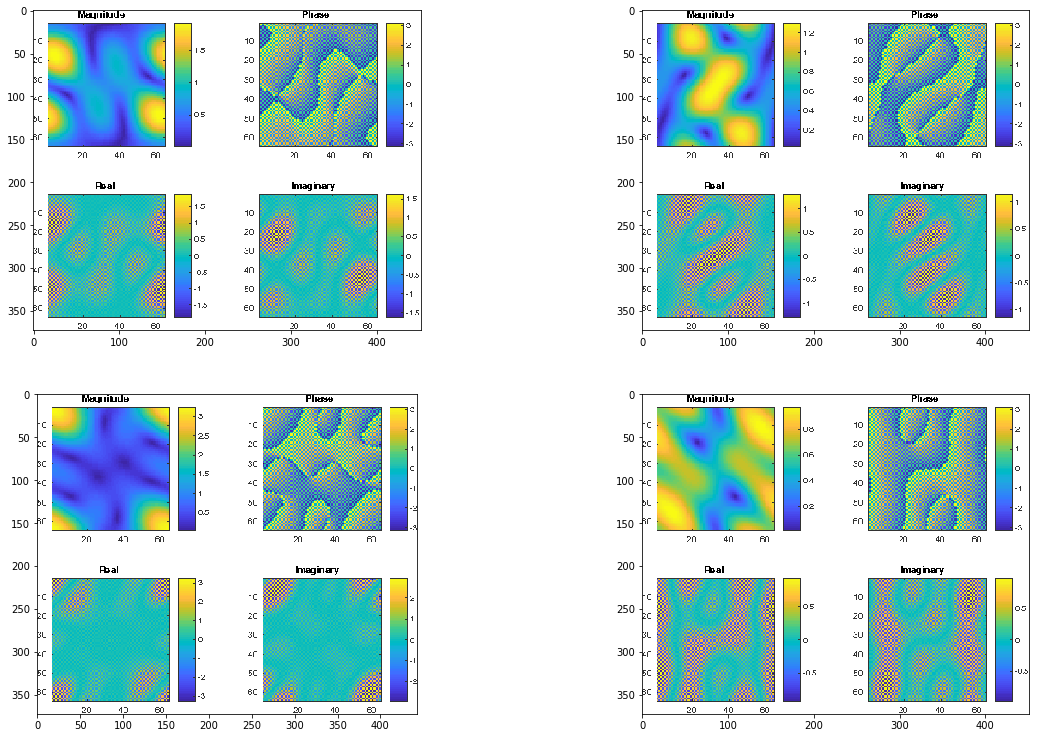

In [41]:
images = []
for img_path in glob.glob('mscripts/*conv1*.eps'):
    images.append(mpimg.imread(img_path))
    
show_figs(images)

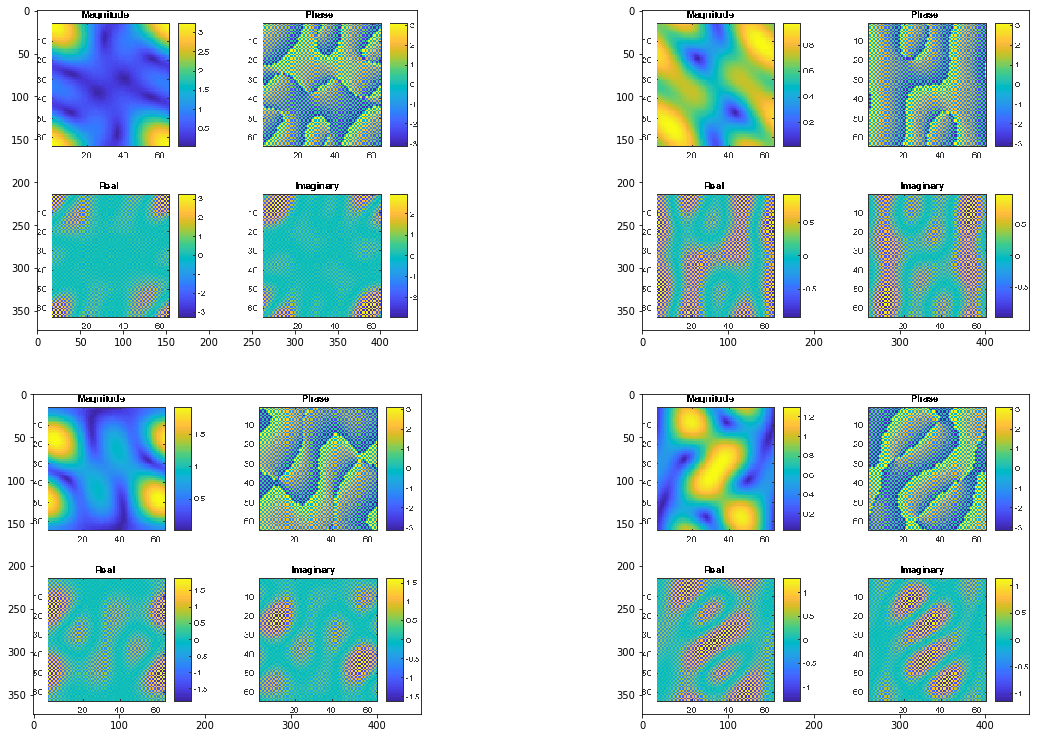

In [42]:
images = []
for img_path in glob.glob('mscripts/*conv2*.eps'):
    images.append(mpimg.imread(img_path))

show_figs(images)